In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class bandit(object):
    def __init__(self, arms, T):
        self.arms = arms
        self.T = T
        self.histroy = np.zeros(shape=(self.T, self.arms))
        self.opt_reward = np.zeros(self.T)
        
        self.mu = np.random.normal(0, 1, self.arms)
        self.opt_arm = np.argmax(self.mu)
        
        for t in range(T):
            self.histroy[t] = np.random.normal(self.mu, 1, self.arms)

        self.opt_reward = (self.mu.max()*np.ones(T))

    def get_rewards(self, t):   
        return self.histroy[t]

    

class algorithm(object):
    def __init__(self, arms, T):
        self.arms = arms
        self.T = T
        self.Q = np.zeros(shape=(self.T+1, self.arms))
        self.arm_cnt = np.zeros(self.arms)
        self.history = np.zeros(self.T)
        self.arm_chosen = np.zeros(self.T)

    def update_Q(self, arm, reward, t):
        # print(self.Q.shape, arm, reward, t)
        self.Q[t+1][arm] = ((self.Q[t][arm]*self.arm_cnt[arm])+reward)/(self.arm_cnt[arm]+1)
        self.arm_cnt[arm] += 1
        self.history[t] = reward



class Greedy(algorithm):
    def __init__(self, arms, T, N):
        super().__init__(arms, T)
        self.N = N//self.arms
        self.cur_arm = [0, self.N]

    def pull_arm(self, t):
        if self.cur_arm[0] < self.arms:
            self.cur_arm[1] -= 1
            a = self.cur_arm[0]
            if self.cur_arm[1] <= 0:
                self.cur_arm[1] = self.N
                self.cur_arm[0] += 1
            return a
        else:
            return np.argmax(self.Q[t])


class E_Greedy(algorithm):
    def __init__(self, arms, T, e):
        super().__init__(arms, T)
        self.e = e

    def pull_arm(self, t):
        if np.random.uniform(0.,1., 1) > 1-self.e:
            return np.argmax(self.Q[t])
        else:
            return np.random.randint(0, self.arms)

class UCB(algorithm):
    def __init__(self, arms, T, c):
        super().__init__(arms, T)
        self.c = c

    def pull_arm(self, t):
        return np.argmax(self.Q[t] + self.c*np.sqrt( np.log(t)/(self.arm_cnt+0.01) ))


class Gradient(algorithm):
    def __init__(self, arms, T, a):
        super().__init__(arms, T)
        self.a = a
        self.r_sum = 0

    def update_Q(self, arm, reward, t):
        self.r_sum += reward 
        Q_buf = self.Q[t][arm]
        self.Q[t+1] = self.Q[t] - self.a*(reward - self.r_sum/(t+1))*self.soft_max(t)
        # print(self.a*(self.r_sum/(t+1))*(1-self.soft_max()[arm]))
        self.Q[t+1][arm] = Q_buf + self.a*(reward - self.r_sum/(t+1))*(1-self.soft_max(t)[arm])
        self.history[t] = reward

    def soft_max(self, t):
        return np.exp(self.Q[t]+0.01)/np.sum(np.exp(self.Q[t]+0.01))

    def pull_arm(self, t):
        s = self.soft_max(t)
        if not np.isfinite(s).all():
            print(self.Q[t], s)
        return np.random.choice(self.arms, 1, p=self.soft_max(t))[0]



In [3]:
arms = 10
T = 1000
times = 20

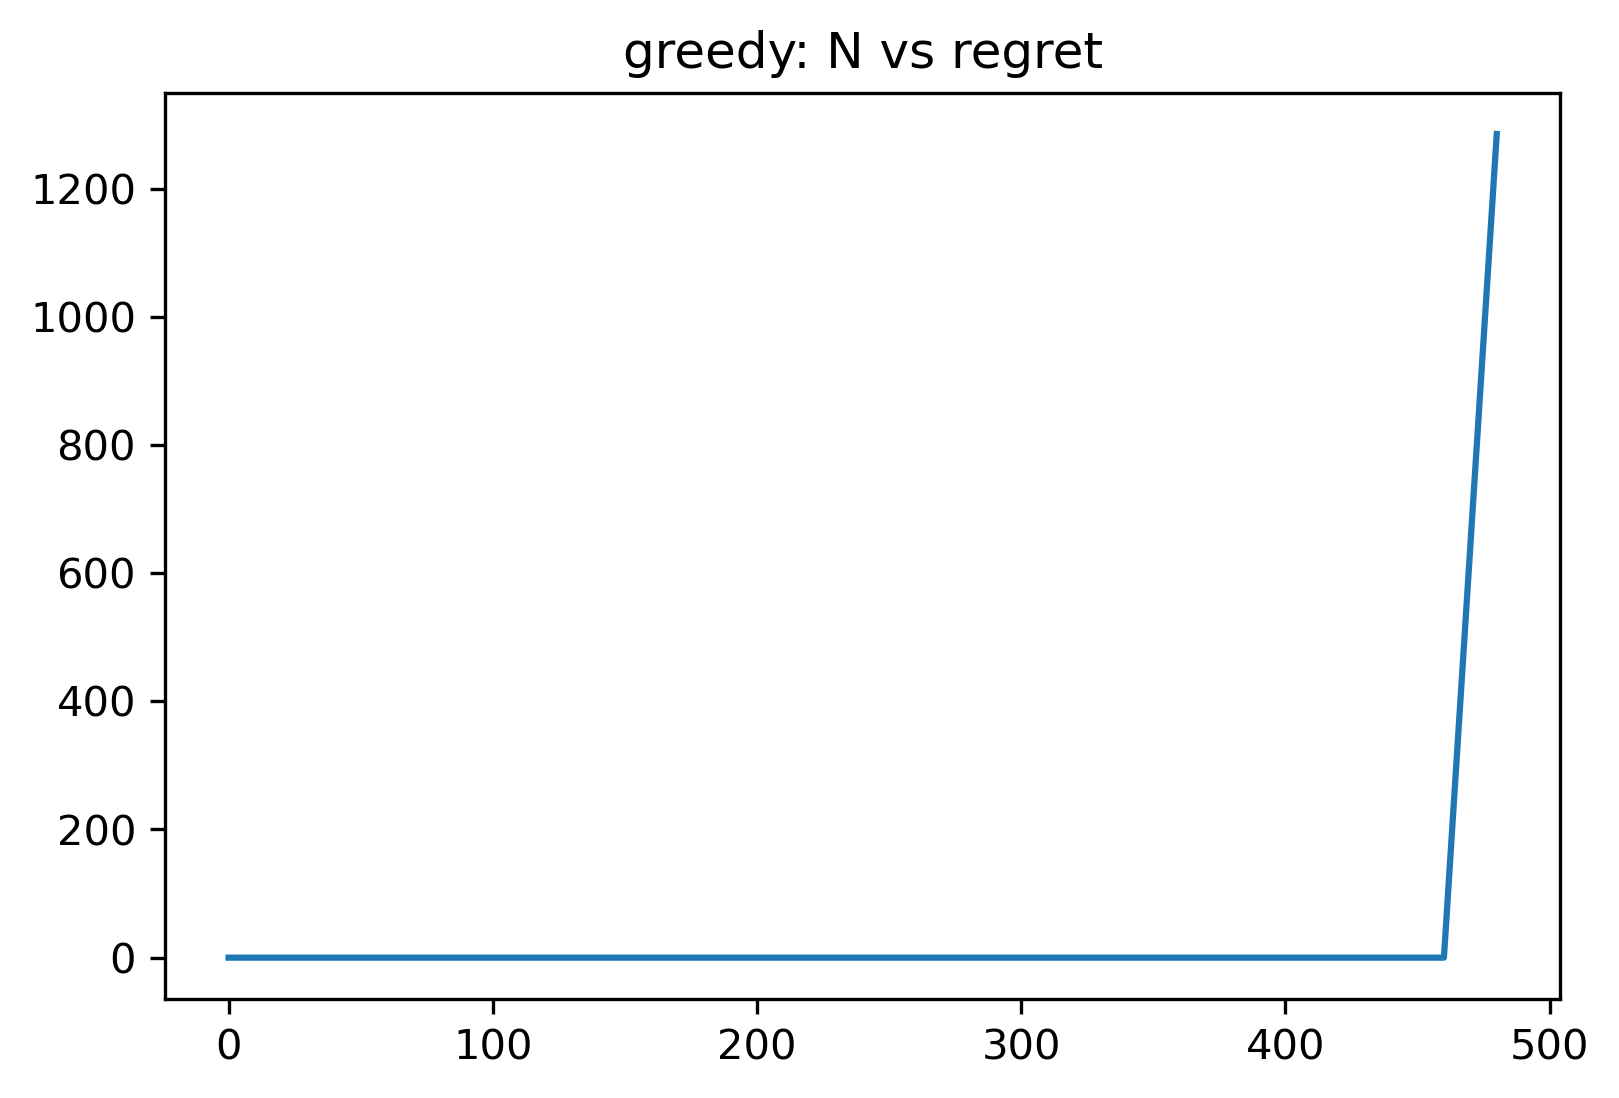

In [4]:
p_list = np.arange(0,500,20)
res = np.zeros(shape=(times, len(p_list)))

for i in range(times):
    b = bandit(arms, T)
    for pi,p in enumerate(p_list):
        g = Greedy(arms, T, N=p)
        for t in range(T):
            r = b.get_rewards(t)            
            a = g.pull_arm(t)
            g.arm_chosen[t] = a
            g.update_Q( a, r[a], t )

    res[i][pi] = (b.opt_reward-g.history).cumsum()[-1]

fig, ax1 = plt.subplots(dpi=300)
ax1.plot(p_list, np.mean(res, axis=0), label='greedy')
ax1.set_title('greedy: N vs regret')
plt.show()


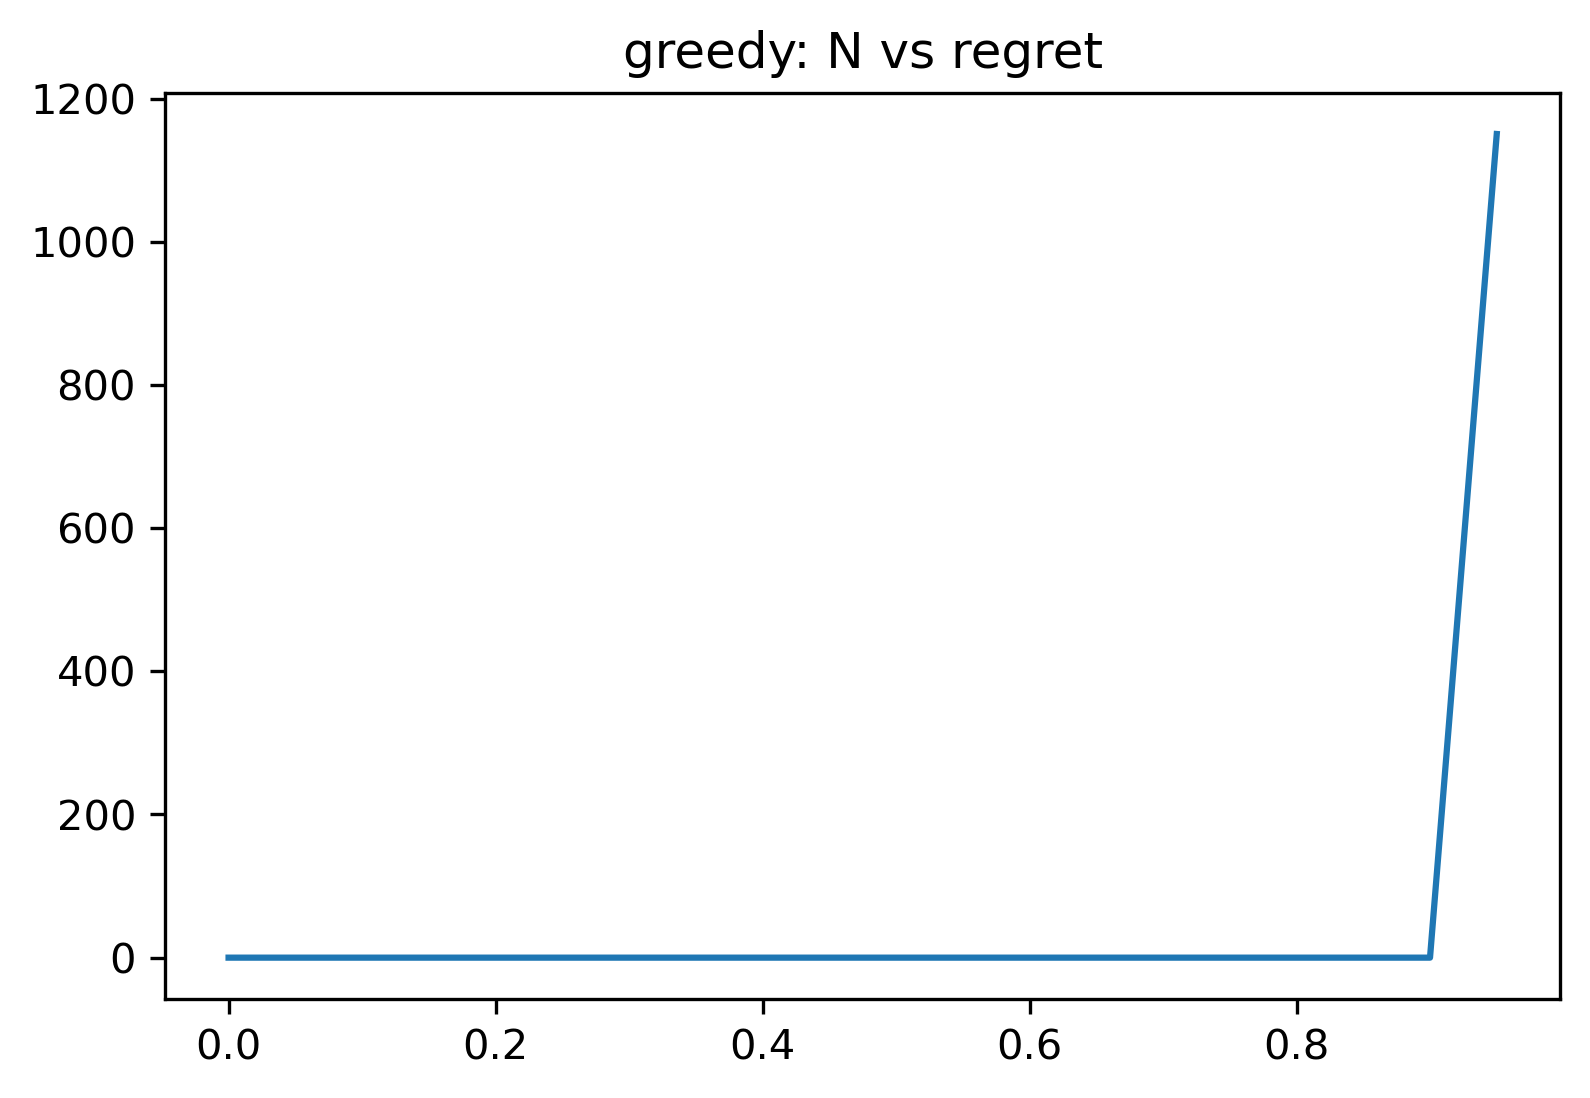

In [5]:
p_list = np.arange(0,1,0.05)
res = np.zeros(shape=(times, len(p_list)))

for i in range(times):
    b = bandit(arms, T)
    for pi,p in enumerate(p_list):
        eg = E_Greedy(arms, T, e=p)
        for t in range(T):
            r = b.get_rewards(t)           
            a = eg.pull_arm(t)
            eg.arm_chosen[t] = a
            eg.update_Q( a, r[a], t )

    res[i][pi] = (b.opt_reward-eg.history).cumsum()[-1]

fig, ax1 = plt.subplots(dpi=300)
ax1.plot(p_list, np.mean(res, axis=0), label='greedy')
ax1.set_title('e-greedy: e vs regret')
plt.show()

<ipython-input-5-c5c1b060778e>:66: RuntimeWarning: divide by zero encountered in log
  ucb = self.Q[t] + self.c*np.sqrt( np.log(t)/(self.arm_cnt+0.0001) )
<ipython-input-5-c5c1b060778e>:66: RuntimeWarning: invalid value encountered in sqrt
  ucb = self.Q[t] + self.c*np.sqrt( np.log(t)/(self.arm_cnt+0.0001) )


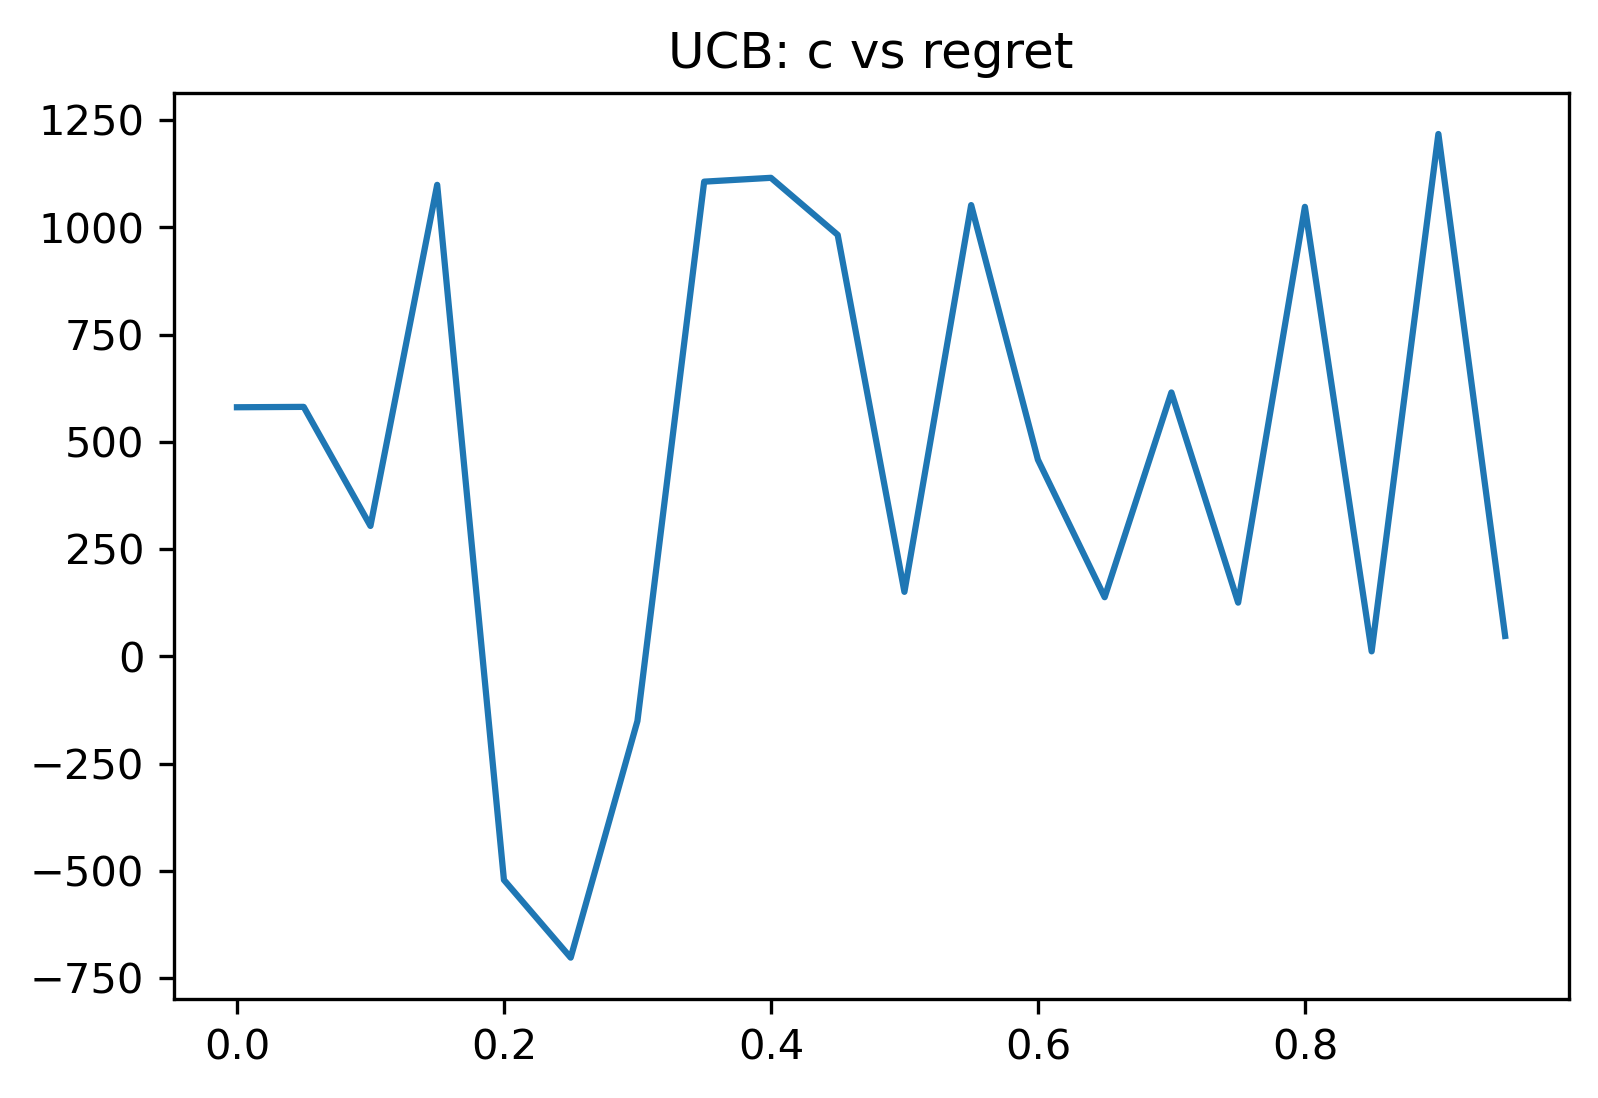

In [13]:
res = []
p_list = np.arange(0,1,0.05)
for p in p_list:
    b = bandit(arms, T)
    ucb = UCB(arms, T, c=p)
    res.append(run_alg(b=b, alg=ucb, T=T))

fig, ax1 = plt.subplots(dpi=300)
# ax1.set_yscale('log')
ax1.plot(p_list, np.array(res), label='greedy')
ax1.set_title('UCB: c vs regret')
# ax1.legend()
plt.show()

In [33]:
res = []
p_list = np.arange(0.01,0.2,0.02)
for p in p_list:
    b = bandit(arms, T)
    d = Gradient(arms, T, a=p)
    res.append(run_alg(b=b, alg=d, T=T))

fig, ax1 = plt.subplots(dpi=300)
ax1.plot(p_list, np.array(res), label='greedy')
ax1.set_title('Gradient: a vs regret')
plt.show()

[-1482.87139524  -224.1990462   -567.64697132   316.83813125
   -28.23965761   218.89136998   415.40828736   712.88223747
   529.61096155   109.32608274] [ 0.  0.  0.  0.  0.  0.  0. nan  0.  0.]


<ipython-input-32-6e1c4a42d23b>:85: RuntimeWarning: overflow encountered in exp
  return np.exp(self.Q[t]+0.01)/np.sum(np.exp(self.Q[t]+0.01))
<ipython-input-32-6e1c4a42d23b>:85: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(self.Q[t]+0.01)/np.sum(np.exp(self.Q[t]+0.01))


ValueError: probabilities contain NaN

<ipython-input-69-09d3e82f4834>:73: RuntimeWarning: divide by zero encountered in log
  return np.argmax(self.Q[t] + self.c*np.sqrt( np.log(t)/(self.arm_cnt+0.01) ))
<ipython-input-69-09d3e82f4834>:73: RuntimeWarning: invalid value encountered in sqrt
  return np.argmax(self.Q[t] + self.c*np.sqrt( np.log(t)/(self.arm_cnt+0.01) ))


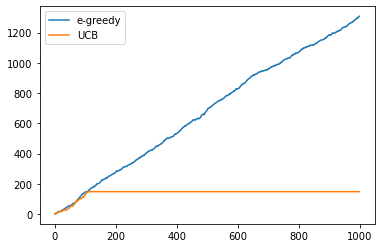

In [97]:
b = bandit(arms, T)
ucb = UCB(arms, T, c=1)
for t in range(T):
    r = b.get_rewards(t)            
    a = ucb.pull_arm(t)
    ucb.arm_chosen[t] = a
    ucb.update_Q( a, r[a], t )

ucb_res = (b.opt_reward-ucb.history).cumsum()


# b = bandit(arms, T)
eg = E_Greedy(arms, T, e=0.01)
for t in range(T):
    r = b.get_rewards(t)            
    a = eg.pull_arm(t)
    eg.arm_chosen[t] = a
    eg.update_Q( a, r[a], t )

eg_res = (b.opt_reward-eg.history).cumsum()

# print(ucb_res, eg_res)

# # ax1.set_yscale('log')
fig, ax1 = plt.subplots()
ax1.plot(np.arange(T), eg_res, label='e-greedy')
ax1.plot(np.arange(T), ucb_res, label='UCB')
ax1.legend()
# print(b.mu.argmax())

# fig, ax2 = plt.subplots()
# ax2.plot(np.arange(T), g.arm_chosen, label='greedy')
# ax2.plot(np.arange(T), eg.arm_chosen, label='e-greedy')
# ax2.plot(np.arange(T), ucb.arm_chosen, label='UCB')
# ax2.plot(np.arange(T), d.arm_chosen, label='gradient')
# ax2.legend()

# # plt.legend()
plt.show()